# Tuning hyperparameters to find the best classification model

Import the necessary libraries:

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, confusion_matrix
import DataProcess as DP

Load the pre-processed, segmented, feature-extracted data:

In [2]:
for subj_n in range(1,10):
    subj_filename='../PAMAP2_Dataset/Protocol/subject10'+str(subj_n)+'.dat'
    dp = DP.dataprocess(subj_filename)
    np.save('data'+str(subj_n)+'.npy', (dp.feat_labels,dp.data_segmented))

In [3]:
datalabels=[]
for i in range(1,10):
    feature_names,datalabelsi=np.load('data'+str(i)+'.npy')
    datalabels.append(datalabelsi)

In [4]:
# Stack data from different subjects into one chunk:
dataset=np.vstack(datalabels)

Split the data into training and test sets.

In [5]:
X = dataset[:,:-1]
y = dataset[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1) Decision Tree Classifier

In [12]:
# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

In [13]:
# Set up the hyperparameter parameterspace
max_depth = np.arange(3,11)
max_feat = np.arange(50, 151)
min_samples_leaf = np.arange(1,11)
min_imp_decrease = np.arange(0.0,0.05,0.005)
max_leaf_nodes = np.arange(10,20)

param_dist = {"max_depth": max_depth,
              "max_features": max_feat,
              "min_samples_leaf": min_samples_leaf,
              "criterion": ["gini", "entropy"],
              "min_impurity_decrease": min_imp_decrease,
              "max_leaf_nodes": max_leaf_nodes}

## 1.1 Randomized Search

In [15]:
# Instantiate grid search object- first I will try the Randomized method to see how
# time-consuming it is
tree_rcv = RandomizedSearchCV(tree, param_dist, cv=9, random_state=42) # 9-fold cv for now

In [16]:
# Fit model to the training data
%time tree_rcv.fit(X_train, y_train)

CPU times: user 16.8 s, sys: 4 ms, total: 16.8 s
Wall time: 16.8 s


RandomizedSearchCV(cv=9, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'min_impurity_decrease': array([ 0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,  0.035,
        0.04 ,  0.045]), 'max_leaf_nodes': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'criterion': ['gini', 'entropy'], 'max_features': array([ 50,  51, ..., 149, 150]), 'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10])},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn

In [17]:
# Print the tuned parameters and score
print("RCV Tuned Decision Tree Parameters: {}".format(tree_rcv.best_params_))
print("RCV Best score is {}".format(tree_rcv.best_score_))

RCV Tuned Decision Tree Parameters: {'min_impurity_decrease': 0.029999999999999999, 'max_leaf_nodes': 14, 'min_samples_leaf': 3, 'criterion': 'entropy', 'max_features': 143, 'max_depth': 5}
RCV Best score is 0.903045903046


In [18]:
y_pred_rand = tree_rcv.predict(X_test)

In [19]:
print(confusion_matrix(y_test, y_pred_rand))
print(classification_report(y_test, y_pred_rand))

[[108   3   0   0   0   0   0   0   0   0   0   0]
 [  0  83  11   0   0   1   0   0   0   1   1   0]
 [  0   0  81   0   0   2   0   0   0   4   2   0]
 [  0   0   0 125   0   0   0   1   3   0   0   0]
 [  0   0   0   0  40   0   0   0   0   0   0   1]
 [  0   0   0   0   0  81   0   0   0   4   3   0]
 [  0   0   0   2   0   0  92   0   0   0   0   0]
 [  0   0   0   2   0   1   1  49   0   0   0   0]
 [  0   0   0   5   0   0   2   0  34   0   0   2]
 [  0   2   0   0   0   5   0   4   0  75   6   1]
 [  0   0   7   0   0   1   0   0   0   6 117   0]
 [  0   0   0   0   8   0   0   7   2   0   0  13]]
             precision    recall  f1-score   support

        1.0       1.00      0.97      0.99       111
        2.0       0.94      0.86      0.90        97
        3.0       0.82      0.91      0.86        89
        4.0       0.93      0.97      0.95       129
        5.0       0.83      0.98      0.90        41
        6.0       0.89      0.92      0.91        88
        7.0    

## 1.2 Regular grid search

In [35]:
params = {"max_depth": max_depth,
              "max_features": max_feat,
              "min_samples_leaf": min_samples_leaf,
              "criterion": ["gini", "entropy"]}
              #"min_impurity_decrease": min_imp_decrease,
              #"max_leaf_nodes": max_leaf_nodes}
tree_cv = GridSearchCV(tree, params, cv=9)

In [ ]:
%time tree_cv.fit(X_train, y_train)

In [ ]:
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

In [ ]:
y_pred = tree_cv.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 2) Logistic Regression Classifier

In [20]:
logreg = LogisticRegression()

In [21]:
c_space =  np.logspace(-5, 8, 15)
logreg_param_grid = {'C': c_space, 
                     'penalty' : ["l1", "l2"],
                     'class_weight': ["balanced", None]}
logreg_rcv = RandomizedSearchCV(logreg, logreg_param_grid, cv=9)
logreg_cv  = GridSearchCV(logreg, logreg_param_grid, cv=9)

In [22]:
%time logreg_rcv.fit(X_train, y_train)

CPU times: user 2min 11s, sys: 12 ms, total: 2min 11s
Wall time: 2min 11s


RandomizedSearchCV(cv=9, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   8.48343e-05,   7.19686e-04,   6.10540e-03,
         5.17947e-02,   4.39397e-01,   3.72759e+00,   3.16228e+01,
         2.68270e+02,   2.27585e+03,   1.93070e+04,   1.63789e+05,
         1.38950e+06,   1.17877e+07,   1.00000e+08]), 'class_weight': ['balanced', None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [23]:
print("Tuned Parameters: {}".format(logreg_rcv.best_params_))
print("Best score is {}".format(logreg_rcv.best_score_))

Tuned Parameters: {'penalty': 'l1', 'C': 3.7275937203149381, 'class_weight': None}
Best score is 0.980694980695


In [24]:
y_pred_logreg_rand = logreg_rcv.predict(X_test)

In [25]:
print(confusion_matrix(y_test, y_pred_logreg_rand))
print(classification_report(y_test, y_pred_logreg_rand))

[[110   0   0   0   0   0   0   0   1   0   0   0]
 [  0  96   1   0   0   0   0   0   0   0   0   0]
 [  0   2  83   0   0   0   0   0   0   1   3   0]
 [  0   0   0 129   0   0   0   0   0   0   0   0]
 [  0   0   0   0  41   0   0   0   0   0   0   0]
 [  0   0   0   0   0  88   0   0   0   0   0   0]
 [  0   0   0   0   0   0  94   0   0   0   0   0]
 [  0   0   0   0   0   0   0  53   0   0   0   0]
 [  0   0   0   0   0   0   1   0  42   0   0   0]
 [  0   0   0   0   0   1   0   0   0  91   1   0]
 [  0   0   0   0   0   0   0   0   0   1 130   0]
 [  0   0   0   0   0   0   0   0   0   0   0  30]]
             precision    recall  f1-score   support

        1.0       1.00      0.99      1.00       111
        2.0       0.98      0.99      0.98        97
        3.0       0.99      0.93      0.96        89
        4.0       1.00      1.00      1.00       129
        5.0       1.00      1.00      1.00        41
        6.0       0.99      1.00      0.99        88
        7.0    

In [30]:
%time logreg_cv.fit(X_train, y_train)

CPU times: user 13min 44s, sys: 328 ms, total: 13min 44s
Wall time: 13min 45s


GridSearchCV(cv=9, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   8.48343e-05,   7.19686e-04,   6.10540e-03,
         5.17947e-02,   4.39397e-01,   3.72759e+00,   3.16228e+01,
         2.68270e+02,   2.27585e+03,   1.93070e+04,   1.63789e+05,
         1.38950e+06,   1.17877e+07,   1.00000e+08]), 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
print("Tuned Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Parameters: {'penalty': 'l1', 'C': 31.622776601683793, 'class_weight': 'balanced'}
Best score is 0.98283998284


In [32]:
y_pred_logreg = logreg_cv.predict(X_test)

In [33]:
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

[[110   0   1   0   0   0   0   0   0   0   0   0]
 [  0  96   0   0   0   0   0   0   0   0   1   0]
 [  0   2  82   0   0   0   0   0   0   1   4   0]
 [  0   0   0 129   0   0   0   0   0   0   0   0]
 [  0   0   0   0  41   0   0   0   0   0   0   0]
 [  0   0   0   0   0  88   0   0   0   0   0   0]
 [  0   0   0   0   0   0  94   0   0   0   0   0]
 [  0   0   0   0   0   0   0  53   0   0   0   0]
 [  0   0   0   0   0   0   0   0  43   0   0   0]
 [  0   0   1   0   0   0   0   0   0  91   1   0]
 [  0   0   0   0   0   1   0   0   0   1 129   0]
 [  0   0   0   1   0   0   0   0   0   0   0  29]]
             precision    recall  f1-score   support

        1.0       1.00      0.99      1.00       111
        2.0       0.98      0.99      0.98        97
        3.0       0.98      0.92      0.95        89
        4.0       0.99      1.00      1.00       129
        5.0       1.00      1.00      1.00        41
        6.0       0.99      1.00      0.99        88
        7.0    

# 3) KNN Classifier

In [8]:
knn = KNeighborsClassifier()

In [9]:
knn_param_grid = {'n_neighbors': np.arange(5,100,5)}
knn_cv = GridSearchCV(knn, knn_param_grid, cv=9)

In [26]:
%time knn_cv.fit(X_train, y_train)

CPU times: user 4min 20s, sys: 72 ms, total: 4min 20s
Wall time: 4min 20s


GridSearchCV(cv=9, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
print("Tuned Parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))

Tuned Parameters: {'n_neighbors': 5}
Best score is 0.953238953239


In [28]:
y_pred_knn = knn_cv.predict(X_test)

In [29]:
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

[[111   0   0   0   0   0   0   0   0   0   0   0]
 [  2  95   0   0   0   0   0   0   0   0   0   0]
 [  1   2  84   0   0   0   0   0   0   1   1   0]
 [  1   0   0 128   0   0   0   0   0   0   0   0]
 [  0   0   0   0  41   0   0   0   0   0   0   0]
 [  0   0   0   1   0  87   0   0   0   0   0   0]
 [  0   0   0   1   0   0  93   0   0   0   0   0]
 [  0   0   0   7   0   0   0  46   0   0   0   0]
 [  0   0   0   7   0   0   0   7  29   0   0   0]
 [  0   0   0   2   0   4   0   0   0  86   1   0]
 [  0   1   0   0   0   0   0   0   0   0 130   0]
 [  0   0   0   0   1   0   0   0   0   0   0  29]]
             precision    recall  f1-score   support

        1.0       0.97      1.00      0.98       111
        2.0       0.97      0.98      0.97        97
        3.0       1.00      0.94      0.97        89
        4.0       0.88      0.99      0.93       129
        5.0       0.98      1.00      0.99        41
        6.0       0.96      0.99      0.97        88
        7.0    

# Random Forest 

In [15]:
rf = RandomForestClassifier()

In [26]:
rf_param_grid = {'n_estimators': [100],
                 'min_samples_split': [2],
                 'min_samples_leaf': [1],
                 'max_depth': [12],
                 'random_state': [42],
                 'class_weight': ['balanced', 'balanced_subsample', None]}

In [27]:
rf_cv = GridSearchCV(rf, rf_param_grid, cv=9)

In [28]:
%time rf_cv.fit(X_train, y_train)

CPU times: user 1min 4s, sys: 32 ms, total: 1min 4s
Wall time: 1min 4s


GridSearchCV(cv=9, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1], 'n_estimators': [100], 'random_state': [42], 'min_samples_split': [2], 'max_depth': [12], 'class_weight': ['balanced', 'balanced_subsample', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
print("Tuned Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))

Tuned Parameters: {'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 42, 'min_samples_split': 2, 'max_depth': 12, 'class_weight': None}
Best score is 0.992277992278


In [31]:
y_pred_rf = rf_cv.predict(X_test)

In [32]:
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[111   0   0   0   0   0   0   0   0   0   0   0]
 [  0  96   0   0   0   0   0   0   0   1   0   0]
 [  0   1  85   0   0   0   0   0   0   2   1   0]
 [  0   0   0 129   0   0   0   0   0   0   0   0]
 [  0   0   0   0  41   0   0   0   0   0   0   0]
 [  0   0   0   0   0  88   0   0   0   0   0   0]
 [  0   0   0   0   0   0  94   0   0   0   0   0]
 [  0   0   0   0   0   0   0  53   0   0   0   0]
 [  0   0   0   0   0   0   0   0  43   0   0   0]
 [  0   0   0   0   0   0   0   0   0  92   1   0]
 [  0   0   1   0   0   0   0   0   0   2 128   0]
 [  0   0   0   0   0   0   0   0   0   0   0  30]]
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00       111
        2.0       0.99      0.99      0.99        97
        3.0       0.99      0.96      0.97        89
        4.0       1.00      1.00      1.00       129
        5.0       1.00      1.00      1.00        41
        6.0       1.00      1.00      1.00        88
        7.0    

## Plotting a learning curve for the random forest model

In [40]:
%time train_sizes, train_scores, test_scores = learning_curve(rf_cv, X, y, cv=5)

CPU times: user 16min 22s, sys: 448 ms, total: 16min 23s
Wall time: 16min 23s


In [44]:
print test_scores

[[ 0.85565476  0.58445441  0.43674699  0.44343891  0.48187311]
 [ 0.78571429  0.97010463  0.95481928  0.9306184   0.90483384]
 [ 0.91964286  0.97458894  0.96686747  0.95022624  0.98187311]
 [ 0.91815476  0.97757848  0.97439759  0.95927602  0.99244713]
 [ 0.91517857  0.98056801  0.98493976  0.96229261  0.98489426]]


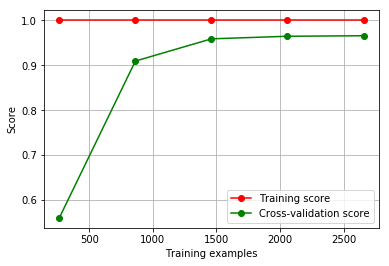

In [43]:
plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.grid()
plt.legend(loc="best")